In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c facial-keypoints-detection

 75% 57.0M/76.3M [00:00<00:00, 91.8MB/s]
100% 76.3M/76.3M [00:00<00:00, 114MB/s] 


In [4]:
!unzip facial-keypoints-detection

Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
import cv2
import glob as gb
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  

In [29]:
with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('data')


In [33]:
# Load the training dataset into memory
train_data = pd.read_csv('data/training.csv')
train_data.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   
3                 38.754115  ...   54.166539            65.598887   
4                 39.094852  ...   64.889521            60.671411   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   
3               50.303165               70.091687                  51.561183   
4               44.962748               73.707387                  44.227141   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   
3                  78.268383   
4                  86.871166   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  
3  193 192 193 194 194 194 193 192 168 111 50 12 ...  
4  147 148 160 196 215 214 216 217 219 220 206 18...  

[5 rows x 31 columns]

In [34]:

# test data
test_data = pd.read_csv('data/test.csv')
test_data.head()


ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...

In [38]:
train_data.shape

(7049, 31)

In [35]:

# check the number of missing values
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [39]:

# using ffill to fill the missing values
train_data.fillna(method='ffill', inplace=True)

In [40]:
# check the number of missing values
train_data.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [44]:

## Analysis of the Images
# %%
im_width, im_height = 96, 96

# %%
# checking the data type of the image column
type(train_data['Image'][0])

str

In [45]:

# convert the image column to numpy array
train_data['Image'] = train_data['Image'].apply(lambda x: np.fromstring(x, sep=' '))

In [46]:

img = []

for i in range(0, 7049):
    img_pixel = train_data['Image'][i].reshape(im_width, im_height)
    img.append(img_pixel)

# %%
# convert the list to numpy array
img = np.array(img)

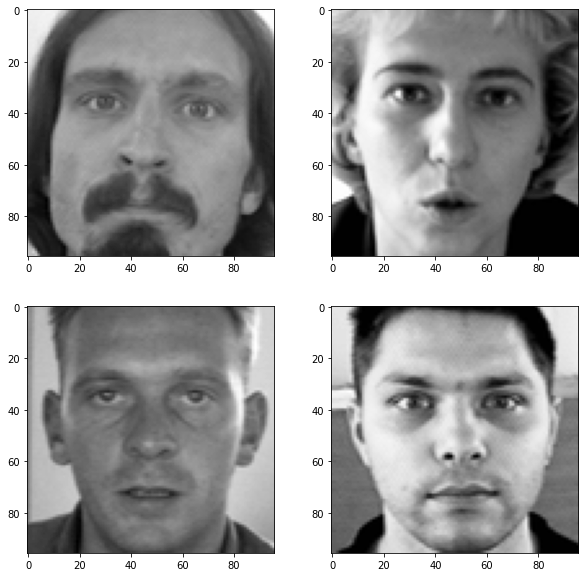

In [48]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img[0], cmap='gray')
ax[0, 1].imshow(img[1], cmap='gray')
ax[1, 0].imshow(img[2], cmap='gray')
ax[1, 1].imshow(img[3], cmap='gray')

In [50]:

from sklearn.model_selection import train_test_split

In [51]:

# separate the features and labels
X = img
y = train_data.drop(['Image'], axis=1)

# %%
# split the data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# %%
# convert the data to float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# %%
# normalize the data
X_train /= 255
X_val /= 255

# %%
# reshape the data
X_train = X_train.reshape(-1, 96, 96, 1)
X_val = X_val.reshape(-1, 96, 96, 1)

In [52]:

# check the shape of the data
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5639, 96, 96, 1), (1410, 96, 96, 1), (5639, 30), (1410, 30))

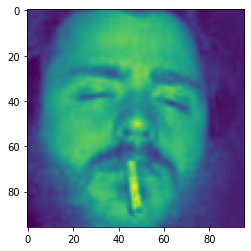

In [54]:
plt.imshow(X_train[1500])
plt.show()

In [57]:
import random

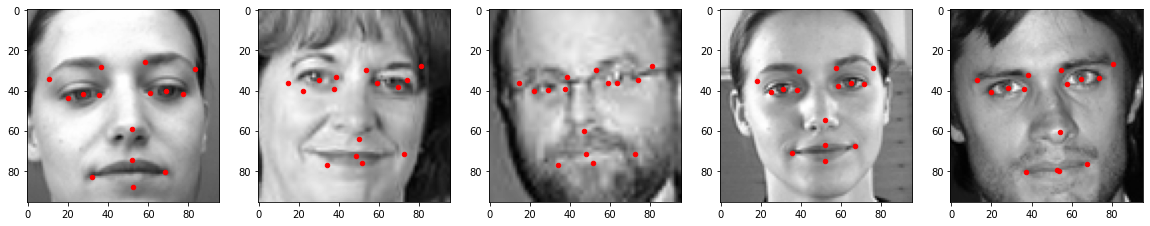

In [60]:
# face keypoints
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    plt.scatter(keypoints[0::2], keypoints[1::2], marker='o', s=20, c='r')

# %%
plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.subplot(1, 5, i+1)
    show_keypoints(X_train[i], y_train.iloc[i])



In [61]:

# define the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(30)
])

# %%
# compile the model
model.compile(optimizer='adam',
                loss='mean_squared_error',          
                metrics=['mae'])

# %%
# define the callbacks
checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


In [63]:
# train the model
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint, earlystop], validation_data=(X_val, y_val))

Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 23.3440 - mae: 3.4355

177/177 [==============================] - 72s 408ms/step - loss: 23.3440 - mae: 3.4355 - val_loss: 15.0087 - val_mae: 2.7124
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 14.7554 - mae: 2.7231

177/177 [==============================] - 71s 402ms/step - loss: 14.7554 - mae: 2.7231 - val_loss: 10.7565 - val_mae: 2.1462
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 14.5732 - mae: 2.6856

177/177 [==============================] - 71s 401ms/step - loss: 14.5732 - mae: 2.6856 - val_loss: 10.1150 - val_mae: 1.8682
Epoch 4/10
177/177 [==============================] - ETA: 0s - loss: 14.2578 - mae: 2.6480

177/177 [==============================] - 71s 401ms/step - loss: 14.2578 - mae: 2.6480 - val_loss: 10.0088 - val_mae: 2.0209
Epoch 5/10
177/177 [==============================] - 70s 395ms/step - loss: 13.2005 - mae: 2.5264 - val_loss: 10.8905 - val_mae: 2.2323
Epoch 6/10
177/177 [==============================] - ETA: 0s - loss: 14.8655 - mae: 2.7297

177/177 [==============================] - 71s 403ms/step - loss: 14.8655 - mae: 2.7297 - val_loss: 9.5366 - val_mae: 1.9179
Epoch 7/10
177/177 [==============================] - 69s 392ms/step - loss: 13.2325 - mae: 2.5199 - val_loss: 13.9772 - val_mae: 2.6323
Epoch 8/10
177/177 [==============================] - 71s 403ms/step - loss: 14.0650 - mae: 2.6376 - val_loss: 9.9362 - val_mae: 1.9877
Epoch 9/10
177/177 [==============================] - 70s 396ms/step - loss: 14.4047 - mae: 2.6766 - val_loss: 10.0811 - val_mae: 2.0724
Epoch 10/10
177/177 [==============================] - 69s 388ms/step - loss: 13.2851 - mae: 2.5449 - val_loss: 10.0406 - val_mae: 2.0381


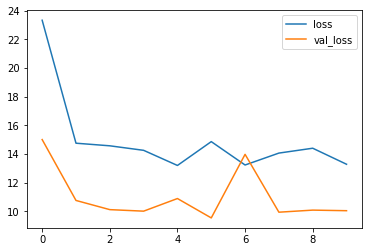

In [64]:
# plot the loss and accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [65]:
# save the model
model.save('model.h5')

In [66]:
# load the model
model = keras.models.load_model('model.h5')
